In [ ]:
import os
import shutil
import random
from zipfile import ZipFile
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Rice Leaf Diseases.zip to Rice Leaf Diseases.zip


In [ ]:
# List the files uploaded
os.listdir()

# Open the ZIP file in read mode
with ZipFile('Rice Leaf Diseases.zip', 'r') as zipObj:
    # Extract all contents of the ZIP file to the specified directory
    zipObj.extractall('Rice Leaf Diseases')

# Verify extraction
os.listdir('Rice Leaf Diseases')

['rice_leaf_diseases']

In [ ]:
data_path = '/content/Rice Leaf Diseases/rice_leaf_diseases'

In [ ]:
def count_images_in_classes(main_directory):
    """
    Counts the number of images in each class folder within the main directory.

    Args:
    - main_directory (str): Path to the main directory containing class folders.

    Returns:
    - None
    """
    # Get the list of class directories
    class_dirs = os.listdir(main_directory)

    # Loop through each class directory
    for class_name in class_dirs:
        class_path = os.path.join(main_directory, class_name)

        # Count the number of images in the class directory
        if os.path.isdir(class_path):
            image_count = len([file for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))])
            print(f"Class '{class_name}' has {image_count} images")
            print("-" * 70)

In [ ]:
count_images_in_classes(data_path)

Class 'Leaf smut' has 40 images
----------------------------------------------------------------------
Class 'Bacterial leaf blight' has 40 images
----------------------------------------------------------------------
Class 'Brown spot' has 40 images
----------------------------------------------------------------------


In [ ]:
# Define paths
data_path = '/content/Rice Leaf Diseases/rice_leaf_diseases'
output_path = '/content/Rice Leaf Diseases/split_data'

# Create directories for split data
split_folders = ['train', 'val', 'test']
class_names = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

for folder in split_folders:
    for class_name in class_names:
        os.makedirs(os.path.join(output_path, folder, class_name), exist_ok=True)

# Helper function to split data
def split_data(class_name):
    class_path = os.path.join(data_path, class_name)
    all_files = os.listdir(class_path)
    random.shuffle(all_files)

    # Calculate split indices
    total_files = len(all_files)
    train_end = int(0.8 * total_files)
    val_end = train_end + int(0.15 * total_files)

    # Split files
    train_data = all_files[:train_end]
    val_data = all_files[train_end:val_end]
    test_data = all_files[val_end:]

    # Move files to corresponding folders
    for file in train_data:
        shutil.copy(os.path.join(class_path, file), os.path.join(output_path, 'train', class_name, file))
    for file in val_data:
        shutil.copy(os.path.join(class_path, file), os.path.join(output_path, 'val', class_name, file))
    for file in test_data:
        shutil.copy(os.path.join(class_path, file), os.path.join(output_path, 'test', class_name, file))

    # Print the number of files in each split
    print(f"Class: {class_name}")
    print(f"  Train: {len(train_data)} images")
    print(f"  Validation: {len(val_data)} images")
    print(f"  Test: {len(test_data)} images")

    return len(train_data), len(val_data), len(test_data)

print("Data split completed.")

Data split completed.


In [ ]:
# Apply splitting for each class
for class_name in class_names:
    train_len, val_len, test_len = split_data(class_name)
    print(f"For {class_name}: Train={train_len}, Validation={val_len}, Test={test_len}")

Class: Bacterial leaf blight
  Train: 32 images
  Validation: 6 images
  Test: 2 images
For Bacterial leaf blight: Train=32, Validation=6, Test=2
Class: Brown spot
  Train: 32 images
  Validation: 6 images
  Test: 2 images
For Brown spot: Train=32, Validation=6, Test=2
Class: Leaf smut
  Train: 32 images
  Validation: 6 images
  Test: 2 images
For Leaf smut: Train=32, Validation=6, Test=2


In [ ]:
train_dir = os.path.join(output_path, 'train')
val_dir = os.path.join(output_path, 'val')
test_dir = os.path.join(output_path, 'test')

In [ ]:
CLASS_NAME = os.listdir(train_dir)
CLASS_NAME

['Leaf smut', 'Bacterial leaf blight', 'Brown spot']

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical', # Use 'categorical' for multi-class classification
    color_mode='rgb',
    batch_size=16,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode='categorical', # returns one-hot encoded labels
    color_mode='rgb',
    batch_size=16,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
)

Found 96 files belonging to 3 classes.
Found 18 files belonging to 3 classes.


In [ ]:
for i in train_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(16, 224, 224, 3), dtype=float32, numpy=
array([[[[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         ...,
         [1.40493286e+02, 1.41493286e+02, 1.44932861e+01],
         [1.40000000e+02, 1.41000000e+02, 1.40000000e+01],
         [1.39301361e+02, 1.39602722e+02, 1.46986389e+01]],

        [[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         ...,
         [1.41751678e+02, 1.42126678e+02, 1.70016785e+01],
         [1.41250000e+02, 1.41625000e+02, 1.65000000e+01],
         [1.40988007e+02, 1.41101013e+02, 1.76352882e+01]],

        [[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         ...,
         

In [ ]:
def balance_visual(dataset):
    class_names = dataset.class_names
    counts = [0] * len(class_names)

    for images, labels in dataset:
        for label in labels:
            label_int = np.argmax(label) # Convert (one hot encoded) to integer so u can visualize it
            counts[label_int] += 1

    plt.figure(figsize=(6,3))
    plt.bar(class_names, counts, color='cornflowerblue', width=0.4)
    plt.xlabel('Class')
    plt.ylabel('Number of Sample')
    plt.title('Class Counts')
    plt.show()

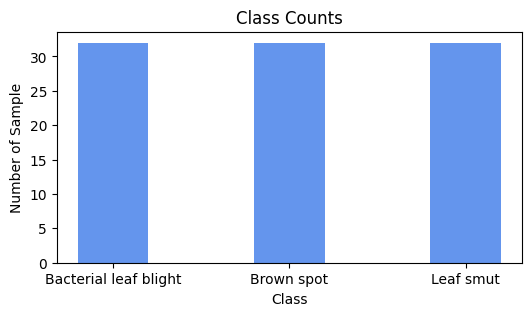

In [ ]:
balance_visual(train_dataset)

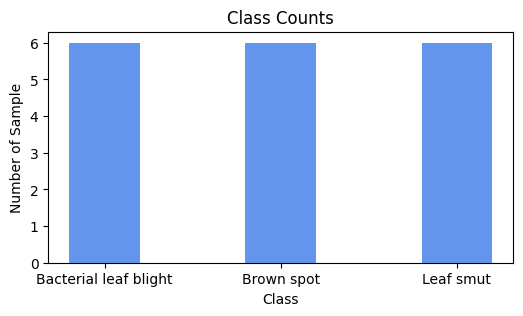

In [ ]:
balance_visual(val_dataset)

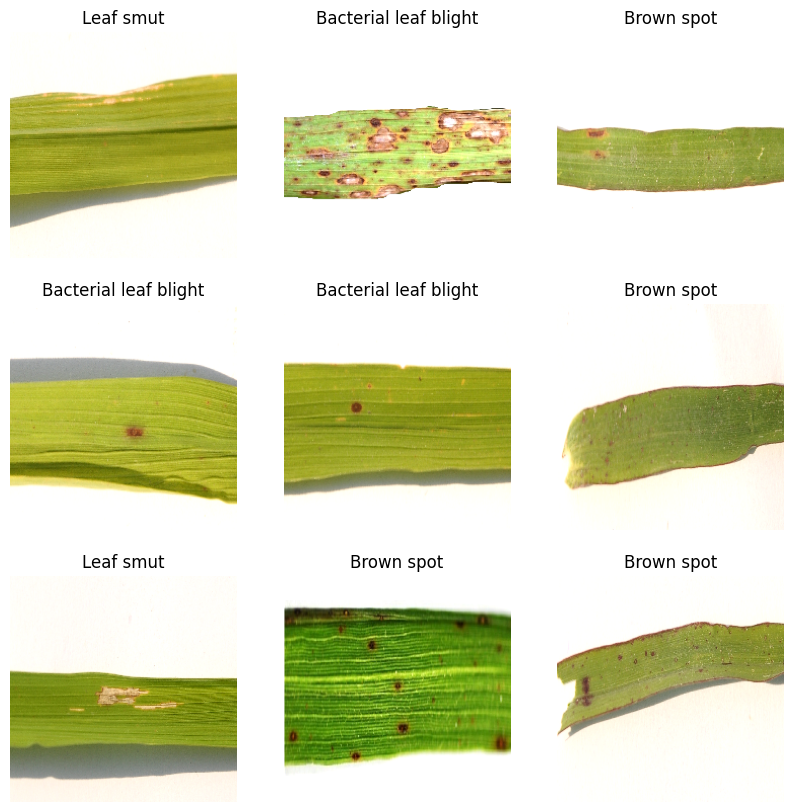

In [ ]:
plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i]/225.)
        plt.title(CLASS_NAME[tf.argmax(labels[i], axis=0).numpy()])
        plt.axis('off')

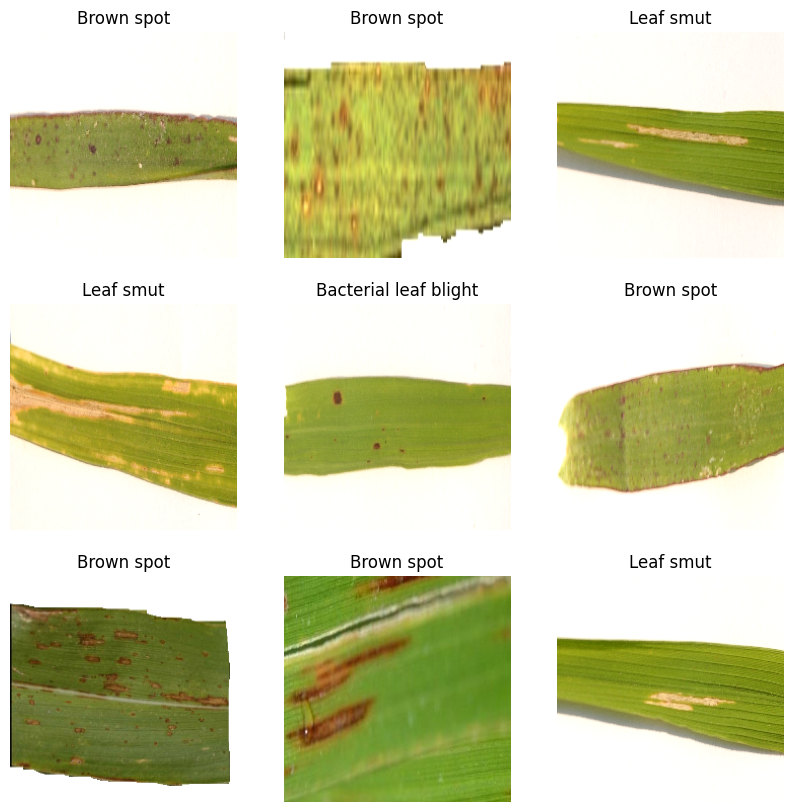

In [ ]:
plt.figure(figsize=(10,10))

for images, labels in val_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i]/225.)
        plt.title(CLASS_NAME[tf.argmax(labels[i], axis=0).numpy()])
        plt.axis('off')

### Data Augmentation

In [ ]:
# Data Augmentation

def scalar(x):
    return x / 255.0

train_datagen = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.4, 0.6],
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=scalar
)

train_dataset_aug = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Image Size
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=123
)


valid_dataset_aug = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False,  # no need for Validation
    seed=123
)

Found 96 images belonging to 3 classes.
Found 18 images belonging to 3 classes.


### Modelling

In [ ]:
def create_mobilenet_model(input_shape=(224, 224, 3), num_classes=3, dropout_rate=0.5):
    # Load MobileNetV2 with pretrained weights, excluding the top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model (so the weights don't get updated during training)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global pooling layer
    x = Dense(1024, activation='relu')(x)  # Fully connected layer
    x = Dropout(dropout_rate)(x)  # Dropout for regularization

    # Output layer
    predictions = Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = create_mobilenet_model()
model.summary()

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,572,803 (13.63 MB)

 Trainable params: 1,314,819 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Define the path to save the best model
checkpoint_filepath = '/content/leaf_model_save.keras'

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,     # Save only the model with the best val_accuracy
    mode='max',              # 'max' because we want to maximize val_accuracy
    verbose=1
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset_aug,
    validation_data=valid_dataset_aug,
    epochs=15,
    shuffle=False,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.2915 - loss: 1.3363
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/leaf_model_save.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3019 - loss: 1.3244 - val_accuracy: 0.3333 - val_loss: 1.0462
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4602 - loss: 1.0493
Epoch 2: val_accuracy improved from 0.33333 to 0.50000, saving model to /content/leaf_model_save.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4600 - loss: 1.0499 - val_accuracy: 0.5000 - val_loss: 0.8185
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.5859 - loss: 0.8891
Epoch 3: val_accuracy improved from 0.50000 to 0.66667, saving model to /content/leaf_model_save.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5885 - loss: 0.8850 - val_accuracy: 0.6667 - val_loss: 0.6978
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.6594 - loss: 0.7712
Epoch 4: val_accuracy d

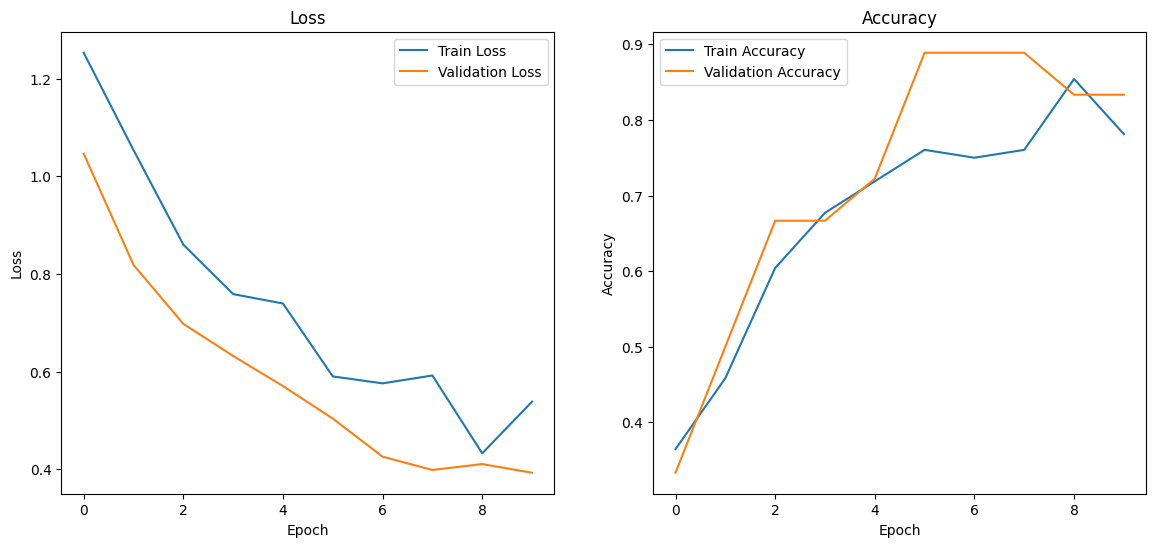

In [ ]:
# Plot training & validation loss and accuracy
def plot_history(history):
    plt.figure(figsize=(14, 6))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot the training history
plot_history(history)

In [ ]:
# Load the saved weights
model.load_weights('/content/leaf_model_save.keras')

# Function to preprocess image and make predictions
def predict_and_display(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224, 3))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Display the image
    img_to_display = image.load_img(image_path, target_size=(224, 224, 3))
    plt.imshow(img_to_display)
    plt.axis('off')  # Turn off the axis
    plt.title(f"Predicted: {CLASS_NAME[predicted_class]}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


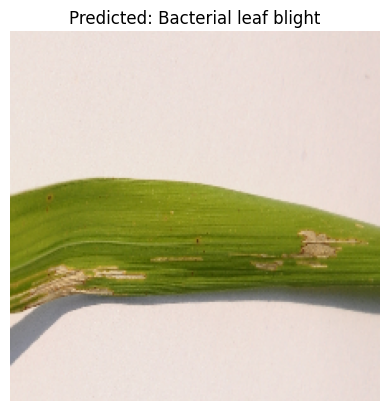

In [ ]:
image_path_to_test = '/content/Rice Leaf Diseases/split_data/test/Bacterial leaf blight/DSC_0397.JPG'
predict_and_display(image_path_to_test, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


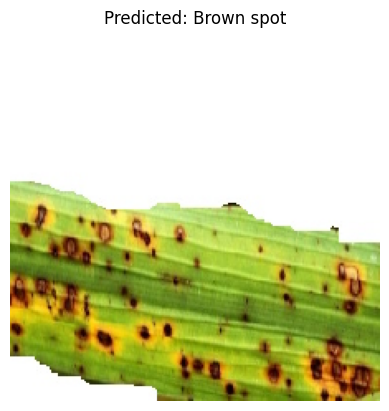

In [ ]:
image_path_to_test = '/content/Rice Leaf Diseases/split_data/test/Brown spot/DSC_0100.jpg'
predict_and_display(image_path_to_test, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


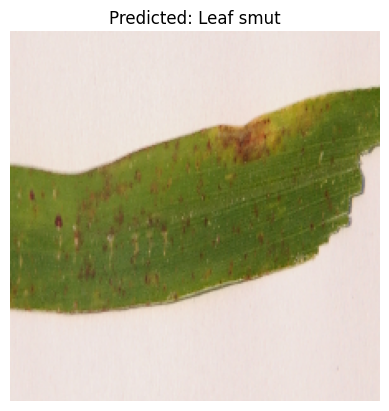

In [ ]:
image_path_to_test = '/content/Rice Leaf Diseases/split_data/test/Leaf smut/DSC_0339.jpg'
predict_and_display(image_path_to_test, model)